# Show behavior predictions for specific neural models

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model
import sys

from disp import set_plot
from my_torch import skl_fit_ridge
from time_stats import csd_multi, coh_multi

cc = np.concatenate

STRAINS = ['NM91', 'ZH23']
PTRAIN = .8
NSPLIT = 30

FIT_LIN = skl_fit_ridge

ALPHA = 10

FPS = 30.03
DT = 1/FPS

In [2]:
FSTRAIN = 'data/simple/strains.csv'

MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()
NTRAIN = int(round(PTRAIN*NTR))

# Population MA model predicting motion

In [3]:
TARG_BHV = 'MTN'
LABELS = {
    'MTN': 'Motion',
}

TWDW = 1
TARG = f'{TARG_BHV}_MN_{TWDW}'

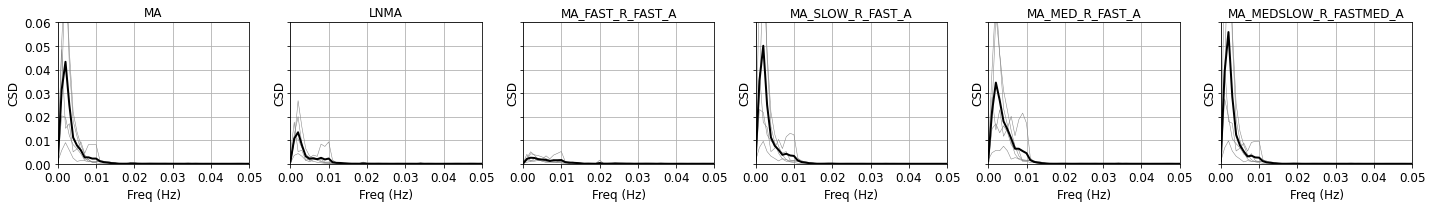

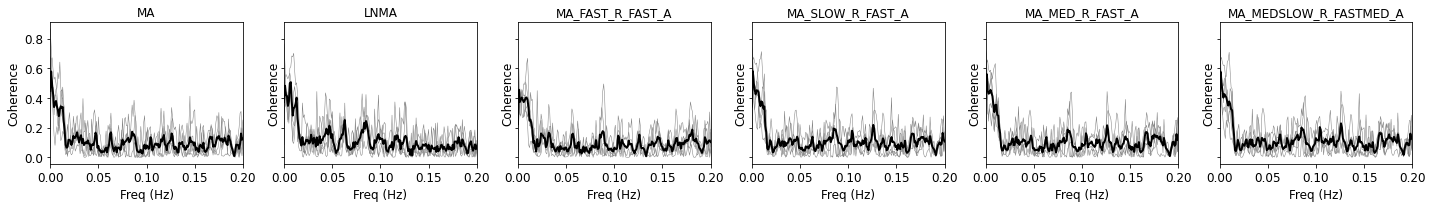

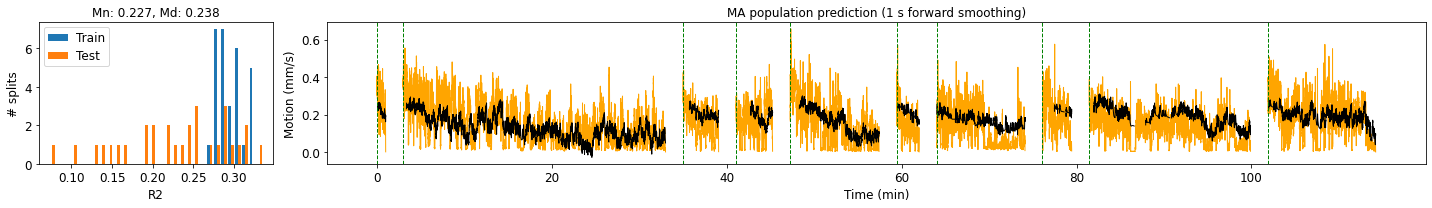

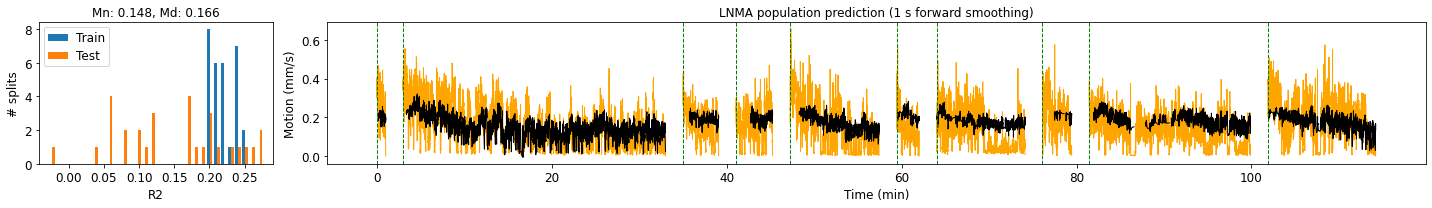

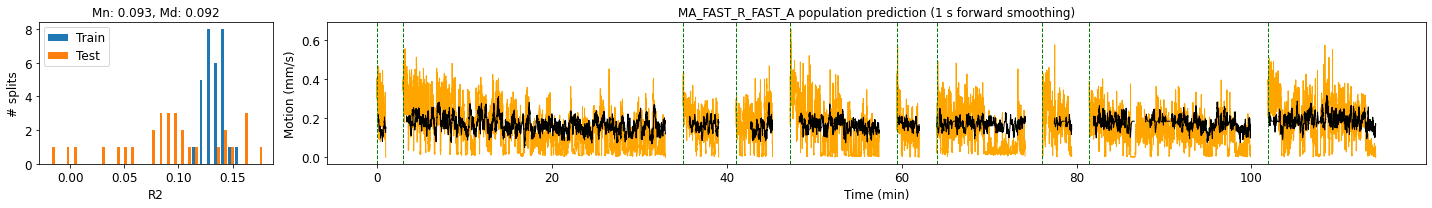

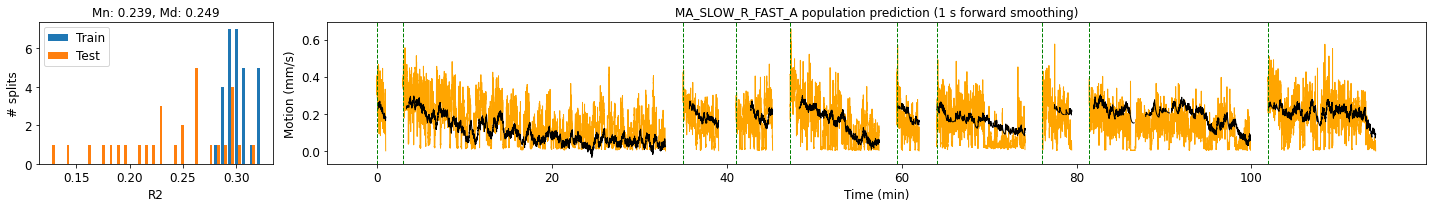

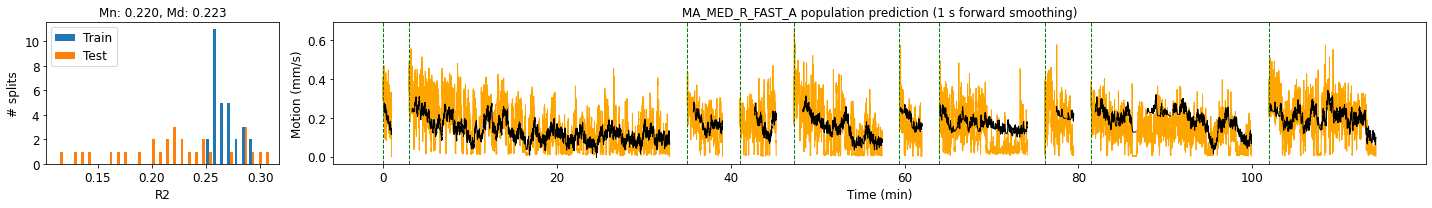

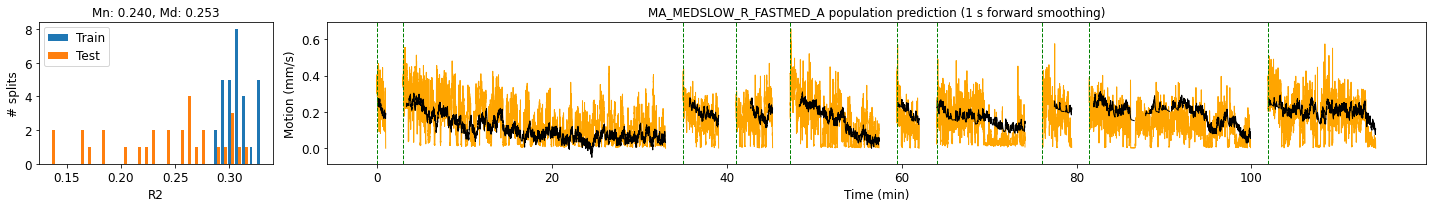

In [7]:
LOAD_DIRS_NRL_MDLS = [
    ('neur_basic', 'ma'),  # full MA ppln
    ('neur_basic', 'lnma'),  # full LN ppln
    ('ma_pert', 'ma_fast_r_fast_a'),  # fast-int-fast-ad
    ('ma_pert', 'ma_slow_r_fast_a'),  # slow-int-fast-ad
    ('ma_pert', 'ma_med_r_fast_a'),  # med-int-fast-ad
    ('ma_pert', 'ma_medslow_r_fastmed_a'),  # medslow-int-fastmed-ad
]

ISPLIT_XPL = 0
TEST_ITRS = [0, 3, 4, 5, 6, 7, 8, 9, 13, 15]

ISPLITS_COH = range(5)

fig_csd, axs_csd = plt.subplots(1, len(LOAD_DIRS_NRL_MDLS), figsize=(20, 3), tight_layout=True, sharey=True)
_, axs_coh = plt.subplots(1, len(LOAD_DIRS_NRL_MDLS), figsize=(20, 3), tight_layout=True, sharey=True)

r2_test_all = []

for cmdl, (LOAD_DIR, NRL_MDL) in enumerate(LOAD_DIRS_NRL_MDLS):
    FSAVE = f'data/simple/mlv/{LOAD_DIR}/baker_{NRL_MDL}_{"_".join(STRAINS).lower()}_{TARG_BHV.lower()}_ridge_alpha_{ALPHA}_masked.npy'

    data = np.load(FSAVE, allow_pickle=True)[0]
    r2_train = data['r2_train'][TARG]
    r2_test = data['r2_test'][TARG]
    
    r2_test_all.append(r2_test)

    gs = gridspec.GridSpec(1, 5)

    fig = plt.figure(figsize=(20, 3), tight_layout=True)
    axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1:])]

    # R2 histogram
    axs[0].hist(np.transpose([r2_train, r2_test]), bins=30)
    axs[0].legend(['Train', 'Test'])
    set_plot(axs[0], x_label='R2', y_label='# splits', title=f'Mn: {r2_test.mean():.3f}, Md: {np.median(r2_test):.3f}')

    # example predictions

    t_offset = 0
    t_spacing = 120

    for itr in TEST_ITRS:
        y = data['ys_test'][TARG][ISPLIT_XPL][itr]
        y_hat = data['y_hats_test'][TARG][ISPLIT_XPL][itr]
        t = np.arange(len(y))/FPS

        axs[1].plot((t + t_offset)/60, y, c='orange', lw=1)
        axs[1].plot((t + t_offset)/60, y_hat, c='k', lw=1)

        axs[1].axvline(t_offset/60, lw=1, color='g', ls='--')

        t_offset += t[-1] + t_spacing

    set_plot(axs[1], x_label='Time (min)', y_label=f'{LABELS[TARG_BHV]} (mm/s)', title=f'{NRL_MDL.upper()} population prediction ({TWDW} s forward smoothing)', font_size=12)
    
    # coherence between targets and predictions
    csds = []
    cohs = []
    for isplit in ISPLITS_COH:
        y_split = data['ys_test'][TARG][isplit]
        y_hat_split = data['y_hats_test'][TARG][isplit]
        
        f_csd, csd = csd_multi(y_split, y_hat_split, dt=DT, df=.001)
        f_coh, coh = coh_multi(y_split, y_hat_split, dt=DT, df=.001)
        
        axs_csd[cmdl].plot(f_csd, csd, c='gray', lw=.5)
        axs_coh[cmdl].plot(f_coh, coh, c='gray', lw=.5)
        
        csds.append(csd)
        cohs.append(coh)
        
    axs_csd[cmdl].plot(f_csd, np.mean(csds, 0), c='k', lw=2)
    axs_coh[cmdl].plot(f_coh, np.mean(cohs, 0), c='k', lw=2)
    
    set_plot(axs_csd[cmdl], x_lim=(0, .05), y_lim=(0, .06), x_label='Freq (Hz)', y_label='CSD', title=f'{NRL_MDL.upper()}')
    set_plot(axs_coh[cmdl], x_lim=(0, .2), x_label='Freq (Hz)', y_label='Coherence', title=f'{NRL_MDL.upper()}')
    
for ax in axs_csd:
    ax.grid()
    
fig_csd.savefig('supp/6_csd.svg')

In [8]:
stats.ttest_ind(r2_test_all[-1], r2_test_all[-2])

Ttest_indResult(statistic=1.441977969857605, pvalue=0.15468680717747535)

In [9]:
r2_test_all[0]

array([0.28903806, 0.27184052, 0.18685427, 0.16033741, 0.31001682,
       0.31638732, 0.25530346, 0.21314497, 0.24230468, 0.19709113,
       0.19889485, 0.25397402, 0.1596757 , 0.24860433, 0.30930268,
       0.23453112, 0.07206492, 0.21512643, 0.12545948, 0.1919366 ,
       0.14823742, 0.33602578, 0.2805734 , 0.10388889, 0.22655778,
       0.28739129, 0.1343896 , 0.28768885, 0.24785285, 0.29914138])